In [121]:
## Import all important libraries
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.support.wait import WebDriverWait
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
from string import ascii_uppercase
from collections import Counter
import pandas as pd
import re

In [122]:
def hover(browser, xpath):
    element_to_hover_over = browser.find_element_by_xpath(xpath)
    hover = ActionChains(browser).move_to_element(element_to_hover_over)
    hover.perform()
def getCredentials(path):
    f = open(path, "r")
    return(str.split(f.read(),"\n"))
def makeChromeSession(url):
    driver = webdriver.Chrome("D:\Basic Software\chromedriver_win32/chromedriver.exe")
    driver.get(url)
    return(driver)
def putStringUsingId(driver,id,txt):
    element = WebDriverWait(driver, 50).until(lambda x: x.find_element_by_id(id))
    element.send_keys(txt)
def clickElementByXpath(driver,St,Num=0):
    element = WebDriverWait(driver, 50).until(lambda x: x.find_elements_by_xpath(St))
    driver.implicitly_wait(4)
    element[Num].click()
def convertSeleniumPageToBeautifulSoup(driver,parser):
    return(BeautifulSoup(driver.page_source, parser))
def detailedQuestionInformation(DetailedResult_Page):
    index = 1
    allQuestions = {}
    for i in DetailedResult_Page.findAll("div",{"class":"col600"}):
        questionDetails = {}
#         Print Question
#         print(i.div.text)
        questionDetails['Question'] = i.div.text
        correctAnswer = i.findAll("p")[0].text.split('Selected answer:')[0].split(":")[1].strip().split(" ")
        selectedAnswer = i.findAll("p")[0].text.split('Selected answer:')[1].strip().split(" ")
#         print("Selected Answer")
#         print(selectedAnswer)
        correctAnswerlst = []
        selectedAnswerlst = []
        questionDetails['correctAnswer'] = correctAnswerlst
        questionDetails['selectedAnswer'] = selectedAnswerlst
        options = {}
        if len(i.div['class']) == 3:
            allOptions = i.findAll("div",{"class":re.compile("saans editor")})
            for j in range(0,len(allOptions)):
                options[ascii_uppercase[j]+")"] = allOptions[j].text
        elif len(i.div['class']) == 4:
            allOptions = i.findAll("div",{"class":re.compile("saans bbcode")})
            for j in range(0,len(allOptions)):
                options[ascii_uppercase[j]+")"] = allOptions[j].text
        ## Print options
    #     print(options)
        questionDetails['options'] = options
        for j in correctAnswer:
            correctAnswerlst.append(options[j])
        if selectedAnswer[0] != "No":
            for j in selectedAnswer:
                selectedAnswerlst.append(options[j])
        else:
            selectedAnswerlst.append("No Answer given")
        allQuestions["Question "+str(index)] = questionDetails
        ## Print Answers
    #     print("Correct Answer:")
    #     for j in correctAnswer:
    #         print(options[j])
    #     print("Selected Answer:")
    #     for j in selectedAnswer:
    #         print(options[j])
        index = index +1
    return(allQuestions)

In [124]:
## Intializing Variables
EvaluationName = "Survey form"
# EvaluationName = "Git"
testId = ''
numberOfExaminee = 0
column_names = ["Name", "Percentage", "Scored", "Time Taken", "Date"]
summarizedResults = pd.DataFrame(columns = column_names)
summarizedResults = summarizedResults[0:0]
url = 'https://www.classmarker.com'
##
Credentials = getCredentials("config/Credentials.txt")
driver = makeChromeSession(url)
putStringUsingId(driver,'un',Credentials[0])
putStringUsingId(driver,'pw',Credentials[1])
clickElementByXpath(driver,"//input[@name='login' and @value='Login']")
hover(driver,"//*[contains(text(),'Dashboard ')]")
clickElementByXpath(driver,"//*[contains(text(),'Tests') and contains(@href,'/a/tests/')]")
soup = convertSeleniumPageToBeautifulSoup(driver,'html.parser')
## Fetching TestId of Test
for i in soup.findAll("h4",{"class":"test-name name"}):
    if(i.string == EvaluationName):
        clickElementByXpath(driver,"//h4[contains(@class,'test-name name') and contains(text(),'"+EvaluationName+"')]")
        x = i.parent.next_sibling.next_sibling
        testId = re.search('\d+',x.a['href']).group(0)
if testId == '':
    print("Test Not Found")
else:
    print("Test Found: "+testId)
##
clickElementByXpath(driver,"//a[contains(@class,'btn btn-results') and contains(@href,'"+testId+"')]")
## Waiting for Summarized Result Page
WebDriverWait(driver, 50).until(lambda x: x.find_elements_by_xpath('''//h2[contains(@class,"test-name name")]'''))
Result_Page = convertSeleniumPageToBeautifulSoup(driver,'html.parser')
numberOfExaminee = len(Result_Page.findAll("p",{"class":"member-name name"}))
nameList = Result_Page.findAll("p",{"class":"member-name name"})
# valueList have following Info: Percentage, points, Time
# If Test Result Found 
#    Index Value
#    (2)   Per
#    (3)   Score
#    (4)   Time 
#     (2+3) for next
#if Test Result not found
# Only two values i.e. (-,-) (2+2)
valueList = Result_Page.findAll("span",{"class":"value"}) # Percentage, points, Time
dateTimeList = Result_Page.findAll("div",{'class':'col-span-2'}) # Return Date on index 5,7,9,11,15
## Starting Index of valueList and dateTimeList
valueIndex = 2
dateIndex = 5
print("Number of Examinee: "+str(numberOfExaminee))
allInformation = {}
for i in range(0,numberOfExaminee):
    if nameList[i].a is None:
        name = nameList[i].text
        perc = '-'
        score = '-'
        time = '-'
        date = '-'
        valueIndex = valueIndex + 2
        dateIndex = dateIndex + 2
        allInformation[name] = 'Test Not given'
    else:
        nameOfTestGiven = nameList[i].text.replace('\n','')
        name = nameOfTestGiven
        perc = valueList[valueIndex].text
        score = valueList[valueIndex + 1].text
        time = valueList[valueIndex + 2].text
        date = dateTimeList[dateIndex].text.replace('\nDate','')
        dateIndex = dateIndex + 2
        valueIndex = valueIndex + 3
        clickElementByXpath(driver,"//a[contains(@class,'trigger-results-array graylink') and contains(text(),'"+nameOfTestGiven+"')]")
        WebDriverWait(driver, 50).until(lambda x: x.find_elements_by_xpath("//h2[contains(@class,'member-name name') and contains(text(),'"+nameOfTestGiven+"')]"))
        DetailedResult_Page = convertSeleniumPageToBeautifulSoup(driver,'html.parser')
        allInformation[nameOfTestGiven] = detailedQuestionInformation(DetailedResult_Page)
#     printing Details
#     print("Name: "+nameOfTestGiven)
#     print("Percentage : "+perc)
#     print("Score: "+score)
#     print("Time taken: "+time)
#     print("Date : "+date)
    summarizedResults = summarizedResults.append({'Name': name, 'Percentage': perc, 'Scored': score, 'Time Taken': time, 'Date': date}, ignore_index=True)    
#     break;
if summarizedResults.shape[0]==numberOfExaminee:
    print("Results have been made Successfully")
else:
    print("Number of rows in dataframe: "+str(summarizedResults.shape[0]))
    print("Number of rows in website: "+str(numberOfExaminee))
    print("Please check")

Test Found: 1187350
Number of Examinee: 78
Results have been made Successfully


In [125]:
## Code to compute Reults Questionwise if Question is fixed for Test
noOfQuestions = len(allInformation[nameOfTestGiven].keys())
print("Number of Questions: "+str(noOfQuestions))
questionWiseResult = {}
for k in range(1,noOfQuestions+1):
    st = 'Question '+str(k)
    values = {}
    question = allInformation[nameOfTestGiven][st]['Question']
    for i in allInformation:
        if allInformation[i] != 'Test Not given':
            values[i] = allInformation[i][st]['selectedAnswer'][0]
        else:
            values[i] = 'Test Not given'
    questionAndResult = {}
    questionAndResult['Question'] = question
    questionAndResult['Result'] = values
    questionWiseResult[st] = questionAndResult
# print("Question Result")
# print(questionWiseResult)

Number of Questions: 8


What should be the frequency of in-house party/ celebration for entire HIG?


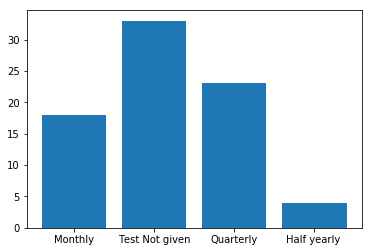

Note:You can select multiple options

What are your food preferences?


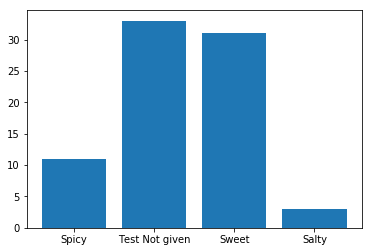

What are your food preferences?


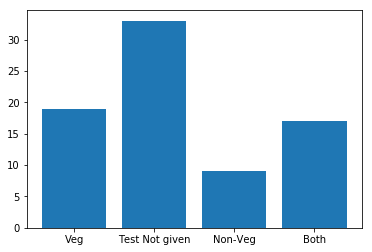

Note:You can select multiple options

You be OK to have  party/ celebrations on :


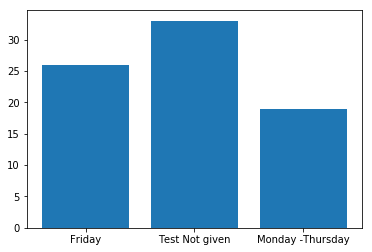

Note:You can select multiple options


Your preference on party/ celebrations ?


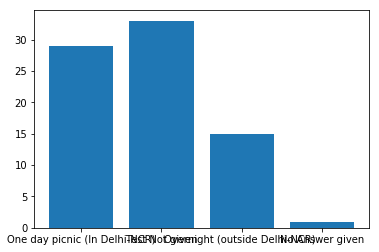

Are you comfortable with dinner with DJ along with Alcohol?


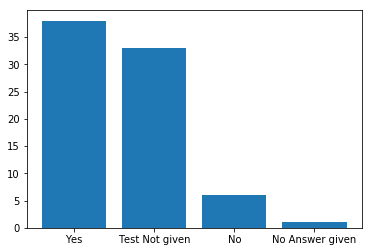

Do you feel you have work life balance in HIG?


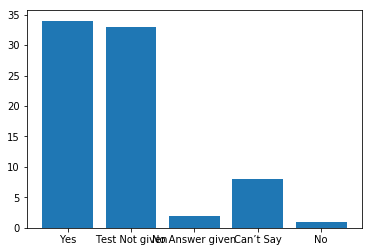

Do you want to be part of organizing committee?


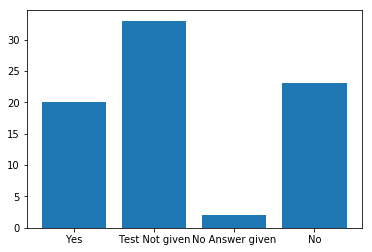

In [126]:
## Analyze Question Results
for i in questionWiseResult:
    print(questionWiseResult[i]['Question'])
    values = questionWiseResult[i]['Result']
    rst = Counter(values.values())
    D = dict(rst)
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()